# Twitter Sentiment Analysis
# ADS Gruppe 24

In [34]:
# initial imports
import pandas as pd
import spacy
spacy.prefer_gpu()
# imports for text processing
from spacy.tokenizer import _get_regex_pattern
from spacy.lang.en.stop_words import STOP_WORDS
import zipfile

In [2]:
import kaggle
# If it doesn't work: 
# 1) Log into Kaggle -> Account -> Create New API Token (downloads kaggle.json)
# 2) (mac only) Press Cmd+Shift+. (period) and place kaggle.json in there 
# https://www.kaggle.com/docs/api
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# Warning about readable file can be ignored

In [3]:
# Download Tweets from kaggle api (only once)
# https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset
api.dataset_download_file('yasserh/twitter-tweets-sentiment-dataset', file_name='Tweets.csv')

False

In [5]:
# extract dataset from zip file
with zipfile.ZipFile('Tweets.csv.zip', 'r') as zipref:
    zipref.extractall()

In [4]:
# Read from downloaded csv
original_tweets = pd.read_csv("Tweets.csv")
original_tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# All possible sentiment values
original_tweets.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [6]:
# Count number of sentiment samples in dataset
original_tweets.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [7]:
original_tweets['text'] = original_tweets.text.astype(str)
original_tweets.loc[:, 'sentiment'] = original_tweets.sentiment.map(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [8]:
# All possible sentiment values
# compare with previous output
original_tweets.sentiment.unique()

array([1, 0, 2])

In [9]:
# Text processing
import re 
import string 
import nltk
from tqdm import tqdm

# Preparing list of stop words and punctuations used for text processing
# (Quelle: SW7 Übung TextClassification)
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Function to remove URLs (Quelle: SW7 Übung TextClassification)
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

# Function to remove hashtags (Quelle: SW7 Übung TextClassification)
def remove_hashtags(text):
    text = re.sub(r"#\w+|\w+-\w+", "", text, flags=re.MULTILINE)
    return text

# (Quelle: SW7 Übung TextClassification)
# Load English tokenizer, tagger, parser, NER and word vectors
nlp =  spacy.load("en_core_web_sm")
# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"
# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

# Remove emojis and non-unicode
# (Quelle: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
def remove_emoji_or_non_unicodes(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Creating tokenizer function (Quelle: SW7 Übung TextClassification aber erweitert mit emoji&non-unicode funktion)
def spacy_tokenizer(sentence):
    
    # emoji und nicht unicode entfernen
    sentence = remove_emoji_or_non_unicodes(sentence)
    
    # Creating our token object, which is used to create documents with linguistic annotations.
    newtokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    newtokens = [word.lemma_.lower().strip() if (word.pos_ != "PRON") & (word.pos_ != "PROPN") else word.lemma_.strip() for word in newtokens ]
    
    # Removing stop words
    newtokens = [ word for word in newtokens if word not in stop_words and word not in punctuations ]
    
    # Remove links
    newtokens = [remove_urls(word) for word in newtokens]
    
    # Remove hashtags
    newtokens = [remove_hashtags(word) for word in newtokens]
    
    # return preprocessed list of tokens
    return newtokens

In [10]:
# Vorzeige Beispiel 2 mit emoji
print('Tweet text:')
print(original_tweets.text[527])
print('\nTokanized:')
spacy_tokenizer(original_tweets.text.values[527])

Tweet text:
i am living in ignorance  :@

Tokanized:


['I', 'live', 'ignorance']

In [11]:
# Train test split
from sklearn.model_selection import train_test_split

# Split the train, test, validation set
train_tweets, test_tweets = train_test_split(original_tweets, test_size = 0.2)

train_tweets.shape, test_tweets.shape

((21984, 4), (5497, 4))

In [12]:
# Label Encoder for classes in sentiment (Quelle: SW7 Übung TextClassification)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_tweets.encoded_sentiment = encoder.fit_transform(train_tweets.sentiment)

encoder = LabelEncoder()
test_tweets.encoded_sentiment = encoder.fit_transform(test_tweets.sentiment)

/var/folders/ms/bdscwb3x6rz1b34v63g367q00000gn/T/ipykernel_6436/2885931097.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_tweets.encoded_sentiment = encoder.fit_transform(train_tweets.sentiment)
/var/folders/ms/bdscwb3x6rz1b34v63g367q00000gn/T/ipykernel_6436/2885931097.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test_tweets.encoded_sentiment = encoder.fit_transform(test_tweets.sentiment)


In [13]:
# split into test and train
X_train = train_tweets.text
X_test = test_tweets.text
y_train = train_tweets.sentiment.values
y_test = test_tweets.sentiment.values

In [14]:
import tensorflow as tf
from tensorflow import keras as keras
from keras import regularizers

In [15]:
# https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=c57f070a31d60dccdbab295b3bbd8904b8fd33f9&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f6675726b616e6f7a6261792f33363931613630386131393264326437336437363333383737613437633739372f7261772f633537663037306133316436306463636462616232393562336262643839303462386664333366392f696d6264636c617373696669636174696f6e2d6f6e6c796576616c756174652e6970796e62&logged_in=false&nwo=furkanozbay%2F3691a608a192d2d73d7633877a47c797&path=imbdclassification-onlyevaluate.ipynb&repository_id=110980065&repository_type=Gist
# "maximum number of words in your vocabulary" -> word vectors
max_features = 20000
# Length of the output sequences (in number of timesteps)
sequence_length = 500

dataset=tf.data.Dataset.from_tensor_slices((X_train.values,y_train)).shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE)

encoder = keras.layers.TextVectorization(max_tokens=max_features,output_mode="int",output_sequence_length=sequence_length)
encoder.adapt(dataset.map(lambda text, label: text))

2022-06-11 17:03:42.948764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
# https://www.kaggle.com/code/sounishnath003/twitter-sentiment

inputs = keras.Input(shape=(1,), dtype=tf.string)
x = encoder(inputs)
x = keras.layers.Embedding(max_features, 64) (x)
x = keras.layers.Dropout(0.5) (x)
x = keras.layers.Conv1D(128, 7, activation='relu') (x)
x = keras.layers.Conv1D(128, 7, activation='relu') (x)
x = keras.layers.MaxPooling1D(5) (x) 
x = keras.layers.Conv1D(64, 7, activation='relu') (x)
x = keras.layers.Dense(64, activation='relu', kernel_initializer = tf.keras.initializers.he_normal) (x)
x = keras.layers.GlobalMaxPooling1D() (x)
x = keras.layers.Dropout(0.5) (x)
x = keras.layers.Dense(3,activation='softmax') (x)

predictions = keras.layers.Dense(3, activation="softmax", name="predictions")(x)
model = keras.Model(inputs, predictions)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 64)           1280000   
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 494, 128)          57472     
                                                                 
 conv1d_1 (Conv1D)           (None, 488, 128)          114816    
                                                             

In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
687/687 [==============================] - 192s 279ms/step - loss: 1.0518 - accuracy: 0.4395 - val_loss: 0.9608 - val_accuracy: 0.5092
Epoch 2/10
687/687 [==============================] - 197s 287ms/step - loss: 0.8554 - accuracy: 0.6537 - val_loss: 0.7920 - val_accuracy: 0.6978
Epoch 3/10
687/687 [==============================] - 198s 288ms/step - loss: 0.7412 - accuracy: 0.7223 - val_loss: 0.7826 - val_accuracy: 0.7011
Epoch 4/10
687/687 [==============================] - 172s 250ms/step - loss: 0.6873 - accuracy: 0.7504 - val_loss: 0.7890 - val_accuracy: 0.7006
Epoch 5/10
687/687 [==============================] - 162s 236ms/step - loss: 0.6519 - accuracy: 0.7682 - val_loss: 0.7992 - val_accuracy: 0.7017
Epoch 6/10
687/687 [==============================] - 161s 234ms/step - loss: 0.6201 - accuracy: 0.7815 - val_loss: 0.7947 - val_accuracy: 0.7004
Epoch 7/10
687/687 [==============================] - 164s 238ms/step - loss: 0.5803 - accuracy: 0.8012 - val_loss: 0.7895 -

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
from sklearn import metrics

prediction = model.predict(X_test).argmax(axis=1)
print('accuracy=', metrics.accuracy_score(y_test, prediction))
print('f1=', metrics.f1_score(y_test, prediction, average='macro'))
print('precision=', metrics.precision_score(y_test, prediction, average='macro'))
print('recall=', metrics.recall_score(y_test, prediction, average='macro'))

accuracy= 0.709114062215754
f1= 0.7086540956336392
precision= 0.7280460990368033
recall= 0.6992194200952316


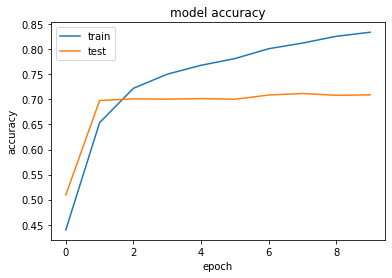

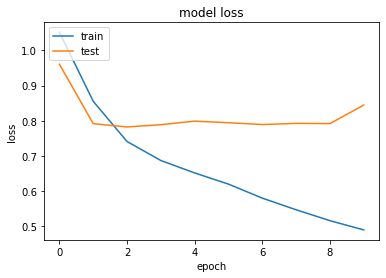

In [62]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plot/accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plot/loss.png')
plt.show()

In [25]:
model.save("ADS_Gruppenarbeit/model")

2022-06-11 17:39:39.712462: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ADS_Gruppenarbeit/model/assets


In [ ]:
#######
# Import saved model
#######

In [26]:
# load model
imported_model = tf.keras.models.load_model('ADS_Gruppenarbeit/model')
imported_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 64)           1280000   
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 494, 128)          57472     
                                                                 
 conv1d_1 (Conv1D)           (None, 488, 128)          114816    
                                                             

In [ ]:
#######
# Import a second datafset with tweets about financial sentiments and evaluate with pretrained model
#######

In [20]:
# Download Tweets from kaggle api (only once)
# https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
api.dataset_download_file('sbhatti/financial-sentiment-analysis', file_name='data.csv')

True

In [27]:
# Read from downloaded csv
new_tweets = pd.read_csv("data.csv")
new_tweets.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [28]:
new_tweets['text'] = new_tweets.Sentence.astype(str)
new_tweets.loc[:, 'sentiment'] = new_tweets.Sentiment.map(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [29]:
results = imported_model.evaluate(new_tweets.Sentence, new_tweets.sentiment, batch_size=128)
print("test loss, test acc:", results)

46/46 [==============================] - 15s 311ms/step - loss: 1.4161 - accuracy: 0.5094
test loss, test acc: [1.4161239862442017, 0.5094146132469177]


In [30]:
prediction = imported_model.predict(new_tweets.Sentence).argmax(axis=1)
print('accuracy=', metrics.accuracy_score(new_tweets.sentiment, prediction))
print('f1=', metrics.f1_score(new_tweets.sentiment, prediction, average='macro'))
print('precision=', metrics.precision_score(new_tweets.sentiment, prediction, average='macro'))
print('recall=', metrics.recall_score(new_tweets.sentiment, prediction, average='macro'))

accuracy= 0.5094145840465594
f1= 0.3385431464358138
precision= 0.4763440105157841
recall= 0.37627990102570535


In [ ]:
#######
# Import a third dataset with different tweets about video games and evaluate with pretrained model
#######

In [31]:
# Download Tweets from kaggle api (only once)
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
api.dataset_download_file('jp797498e/twitter-entity-sentiment-analysis', file_name='twitter_training.csv')

True

In [35]:
with zipfile.ZipFile('twitter_training.csv.zip', 'r') as zipref:
    zipref.extractall()

In [51]:
# Read from downloaded csv
new_tweets = pd.read_csv("twitter_training.csv")
new_tweets.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [53]:
# rename column because dataframe does not have a proper header column. (deletes first column values)
new_tweets.columns = ['Nr.', 'Game', 'sentiment', 'text']
new_tweets.head()

,Nr.,Game,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [55]:
new_tweets['text'] = new_tweets.text.astype(str)
new_tweets.loc[:, 'sentiment'] = new_tweets.sentiment.map(lambda x: 2 if x == 'Positive' else 1 if x == 'Neutral' else 0)

In [57]:
results = imported_model.evaluate(new_tweets.text, new_tweets.sentiment, batch_size=128)
print("test loss, test acc:", results)

584/584 [==============================] - 178s 304ms/step - loss: 1.7337 - accuracy: 0.4138
test loss, test acc: [1.7336560487747192, 0.41377323865890503]


In [60]:
prediction = imported_model.predict(new_tweets.text).argmax(axis=1)
print('accuracy=', metrics.accuracy_score(new_tweets.sentiment, prediction))
print('f1=', metrics.f1_score(new_tweets.sentiment, prediction, average='macro'))
print('precision=', metrics.precision_score(new_tweets.sentiment, prediction, average='macro'))
print('recall=', metrics.recall_score(new_tweets.sentiment, prediction, average='macro'))

accuracy= 0.4137732488852586
f1= 0.4207424218272211
precision= 0.4821725700757064
recall= 0.45383119221288576


In [ ]:
# experimental

In [72]:
# roc curve (unfinished)
# https://scikit-learn.org/stable/visualizations.html

#from sklearn.metrics import RocCurveDisplay
#from sklearn.svm import SVC
#svc = SVC(random_state=42)
#svc.fit(y_train, y_test)
#svc_disp = RocCurveDisplay.from_estimator(svc, y_train, y_test)